# Pipe Flow Heat Transport PDE with Pyomo

Solving the heat transport equation for incompressible fluid flow in a horizontal pipe:

$$\frac{\partial T}{\partial t} + v(t) \frac{\partial T}{\partial x} = \alpha \frac{\partial^2 T}{\partial x^2} + \frac{q(t)}{\rho c_p}$$

Where:
- T(x,t) = temperature at position x and time t
- v(t) = time-varying fluid velocity
- α = thermal diffusivity
- q(t) = time-varying volumetric heat input rate

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyomo.dae import DerivativeVar, ContinuousSet
from pyomo.environ import (
    Var,
    Param,
    Constraint,
    Objective,
    SolverFactory,
    ConcreteModel,
    TransformationFactory,
    value
)

In [2]:
# Constants
ZERO_C = 273.15  # K
THERMAL_DIFFUSIVITY = 0.25  # m²/s
FLUID_DENSITY = 800  # kg/m³
SPECIFIC_HEAT = 2000.0  # J/kg·K

In [3]:
def create_pipe_flow_model(
    L=10.0,
    t_final=5.0,
    n_x=50,
    n_t=50,
    velocity_func=None,
    heat_func=None,
    inlet_func=None,
    thermal_diffusivity=THERMAL_DIFFUSIVITY,
    fluid_density=FLUID_DENSITY,
    specific_heat=SPECIFIC_HEAT
):
    """
    Create Pyomo model for pipe flow heat transport PDE

    Parameters:
    -----------
    L : float, default=10.0
        Length of solar collector section of pipe [m] (domain with heat input)
    t_final : float, default=5.0
        Final simulation time [s]
    n_x : int, default=50
        Number of spatial discretization points
    n_t : int, default=50
        Number of temporal discretization points
    velocity_func : callable, optional
        Function for time-varying fluid velocity v(t) [m/s]
        If None, uses default constant velocity
    heat_func : callable, optional
        Function for time-varying volumetric heat input q(t) [W/m³]
        If None, uses default zero heat input
    inlet_func : callable, optional
        Function for time-varying inlet temperature T_inlet(t) [K]
        If None, uses default constant inlet temperature
    thermal_diffusivity : float, default=THERMAL_DIFFUSIVITY
        Thermal diffusivity α [m²/s]
    fluid_density : float, default=FLUID_DENSITY
        Fluid density ρ [kg/m³]
    specific_heat : float, default=SPECIFIC_HEAT
        Specific heat capacity cp [J/kg·K]

    Returns:
    --------
    model : pyomo.ConcreteModel
        Pyomo model with variables, parameters, and derivative variables defined
        
    Notes:
    ------
    - Creates extended domain: 0 to L_extended = L * 1.1
    - Solar collector section: 0 < x <= L (with heat input)
    - Buffer extension: L < x <= L_extended (no heat input)
    """

    model = ConcreteModel()

    # Extend domain by 10% beyond nominal length
    L_extended = L * 1.1
    model.x = ContinuousSet(bounds=(0, L_extended))
    model.t = ContinuousSet(bounds=(0, t_final))

    # Store both nominal and extended pipe lengths
    model.L = L  # Nominal length with heat input
    model.L_extended = L_extended  # Full domain length

    # Temperature variable with proper bounds
    model.T = Var(model.t, model.x, bounds=(0.0, None))

    # Derivative variables
    model.dTdt = DerivativeVar(model.T, wrt=model.t)
    model.dTdx = DerivativeVar(model.T, wrt=model.x)
    model.d2Tdx2 = DerivativeVar(model.T, wrt=(model.x, model.x))

    # Physical parameters
    model.alpha = Param(initialize=thermal_diffusivity)    # [m²/s]
    model.rho = Param(initialize=fluid_density)      # [kg/m³]
    model.cp = Param(initialize=specific_heat)       # [J/kg·K]

    # Default parameter functions if none provided
    if velocity_func is None:
        def velocity_func(t):
            if t > 3:
                return 5.0
            return 2.5

    if heat_func is None:
        def heat_func(t):
            return 0.0  # heat input [W/m³]

    if inlet_func is None:
        def inlet_func(t):
            #return ZERO_C + 50
            if t > 1:
                return ZERO_C + 55  # inlet temperature [K]
            return ZERO_C + 50  # inlet temperature [K]

    # Store functions for later use
    model.velocity_func = velocity_func
    model.heat_func = heat_func
    model.inlet_func = inlet_func

    # Time-varying parameters (will be initialized after discretization)
    model.v = Param(model.t, mutable=True)
    model.q = Param(model.t, mutable=True)
    model.T_inlet = Param(model.t, mutable=True)

    return model

In [4]:
def add_pde_constraints(model):
    """
    Add PDE constraint and boundary/initial conditions
    """

    # Main PDE constraint - different for physical and extended sections
    @model.Constraint(model.t, model.x)
    def pde_constraint(m, t, x):
        # Skip initial time
        if t == 0:
            return Constraint.Skip
        if x == 0:  # Only skip inlet, NOT outlet
            return Constraint.Skip

        # For nominal physical pipe (0 < x <= L): include heat input
        if x <= m.L:
            # PDE: ∂T/∂t + v(t)∂T/∂x = α∂²T/∂x² + q(t)/(ρcp)
            return (
                m.dTdt[t, x] + m.v[t] * m.dTdx[t, x] ==
                    m.alpha * m.d2Tdx2[t, x] + m.q[t] / (m.rho * m.cp)
            )
        else:
            # For extended section (L < x < L_extended): No heat input
            # PDE: ∂T/∂t + v(t)∂T/∂x = α∂²T/∂x² (no q(t) term)
            return (
                m.dTdt[t, x] + m.v[t] * m.dTdx[t, x] == 
                    m.alpha * m.d2Tdx2[t, x]
            )

    # Initial condition: T(x, 0) = T₀(x) - excluding x=0 (inlet)
    @model.Constraint(model.x)
    def initial_condition(m, x):
        if x == 0:
            return Constraint.Skip
        T_0 = ZERO_C + 50.0  # initial temperature
        return m.T[0, x] == T_0

    # Inlet boundary condition: T(0, t) = T_inlet(t) at all times
    @model.Constraint(model.t)
    def inlet_bc(m, t):
        # Set inlet temperature at x=0
        return m.T[t, 0] == m.T_inlet[t]

    # Note: Outlet boundary condition: ∂T/∂x = 0 at x = L_extended is 
    # implemented after discretization in the main script

    # Dummy objective (required by Pyomo)
    model.obj = Objective(expr=1)

    return model

In [5]:
def solve_model(
    model, n_x=50, n_t=50, max_iter=1000, tol=1e-6, print_level=5, tee=True
):
    """
    Discretize and solve the PDE model using finite differences

    Parameters:
    -----------
    model : pyomo.ConcreteModel
        The Pyomo model created by create_pipe_flow_model()
    n_x : int, default=50
        Number of finite elements for spatial discretization
    n_t : int, default=50
        Number of finite elements for temporal discretization
    max_iter : int, default=1000
        Maximum number of IPOPT solver iterations
    tol : float, default=1e-6
        Solver tolerance for convergence
    print_level : int, default=5
        IPOPT print level (0=no output, 5=detailed output)
    tee : bool, default=True
        Whether to display solver output to console

    Returns:
    --------
    results : pyomo solver results object
        Contains solver status, termination condition, and solution statistics
        
    Notes:
    ------
    - Uses CENTRAL finite difference for spatial discretization (2nd order accuracy)
    - Uses BACKWARD Euler for temporal discretization (stability)
    - Initializes time-varying parameters after discretization
    - Provides uniform initial temperature guess for all variables
    """

    # Apply finite difference discretization
    # Use CENTRAL difference for spatial discretization (better accuracy)
    TransformationFactory('dae.finite_difference').apply_to(
        model, nfe=n_x, scheme='CENTRAL', wrt=model.x
    )

    # Temporal discretization (backward Euler for stability)
    TransformationFactory('dae.finite_difference').apply_to(
        model, nfe=n_t, scheme='BACKWARD', wrt=model.t
    )

    # Note: this outlet constraint can only be added after above 
    # discretization is defined and discrete points exist
    @model.Constraint(model.t)
    def outlet_bc(m, t):
        if t == 0:  # Skip initial time
            return Constraint.Skip
        x_vals = sorted(m.x)
        x_outlet = x_vals[-1]
        x_before = x_vals[-2]
        return m.T[t, x_outlet] == m.T[t, x_before]

    print(f"Discretized with {len(model.x)} x points and {len(model.t)} t points")

    # Initialize time-varying parameters after discretization
    for t in model.t:
        model.v[t].set_value(model.velocity_func(t))
        model.q[t].set_value(model.heat_func(t))
        model.T_inlet[t].set_value(model.inlet_func(t))

    # Provide good initial guess for temperature field
    for t in model.t:
        for x in model.x:
            if t == 0:
                T_guess = ZERO_C + 50.0
            else:
                T_guess = ZERO_C + 50.0
            model.T[t, x].set_value(T_guess)

    # Configure solver with simpler options
    solver = SolverFactory('ipopt')
    solver.options['max_iter'] = max_iter
    solver.options['tol'] = tol
    solver.options['print_level'] = print_level

    print("Solving with IPOPT...")
    results = solver.solve(model, tee=tee)

    return results

In [6]:
def plot_results(model, t_vals_to_plot, x_vals_to_plot, figsize=(12, 8)):
    """
    Plot the temperature field solution with visualization of solar collector section

    Parameters:
    -----------
    model : pyomo.ConcreteModel
        Solved Pyomo model containing temperature solution
    figsize : tuple, default=(12, 8)
        Figure size as (width, height) in inches

    Returns:
    --------
    fig : matplotlib.figure.Figure
        Figure object containing the 4-subplot temperature visualization
        
    Notes:
    ------
    - Subplot 1: 3D surface plot of temperature field
    - Subplot 2: 2D contour plot with time evolution
    - Subplot 3: Temperature profiles at different times
    - Subplot 4: Temperature evolution at different positions
    - Red dashed line marks end of solar collector section (x = L)
    - Extension section (L < x <= L_extended) shown for boundary treatment
    """

    # Extract solution data
    t_vals = list(model.t)
    x_vals = list(model.x)

    # Create meshgrid
    T_grid, X_grid = np.meshgrid(t_vals, x_vals, indexing='ij')

    # Extract temperature values
    temp_vals = np.array([
        [value(model.T[t, x]) for x in x_vals] for t in t_vals
    ])

    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=figsize)

    # 1. 3D surface plot
    ax1.remove()
    ax1 = fig.add_subplot(2, 2, 1, projection='3d')
    surf = ax1.plot_surface(X_grid, T_grid, temp_vals - ZERO_C, cmap='viridis', alpha=0.8)
    ax1.set_xlabel('Position x [m]')
    ax1.set_ylabel('Time t [s]')
    ax1.set_zlabel('Temperature T [°C]')
    ax1.set_title('Temperature Field T(x,t)')
    # Mark the boundary between physical and extended domain
    ax1.axvline(x=model.L, color='red', linestyle='--', alpha=0.7)

    # 2. Contour plot
    contour = ax2.contourf(X_grid, T_grid, temp_vals - ZERO_C, levels=20, cmap='viridis')
    ax2.set_xlabel('Position x [m]')
    ax2.set_ylabel('Time t [s]')
    ax2.set_title('Temperature Contours')
    # Mark the boundary between physical and extended domain
    ax2.axvline(x=model.L, color='red', linestyle='--', alpha=0.7, 
                label=f'end (x={model.L}m)')
    ax2.legend()
    cbar2 = plt.colorbar(contour, ax=ax2)
    cbar2.set_label('Temperature [°C]')

    # 3. Temperature profiles at different times
    time_indices = [t_vals.index(x) for x in t_vals_to_plot]
    for i in time_indices:
        ax3.plot(
            x_vals, temp_vals[i] - ZERO_C, 
            label=f't = {t_vals[i]:.1f}s', linewidth=2
        )
    ax3.set_xlabel('Position x [m]')
    ax3.set_ylabel('Temperature T [°C]')
    ax3.set_title('Temperature Profiles at Different Times')
    # Mark the boundary between physical and extended domain
    ax3.axvline(x=model.L, color='red', linestyle='--', alpha=0.7,
                label=f'end (x={model.L}m)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Temperature evolution at different positions
    pos_indices = [x_vals.index(x) for x in x_vals_to_plot]
    for j in pos_indices:
        add_text = " (extension)" if x_vals[j] > model.L else ""
        ax4.plot(
            t_vals, temp_vals[:, j] - ZERO_C, 
            label=f'x = {x_vals[j]:.1f}m' + add_text, linewidth=2
        )
    ax4.set_xlabel('Time t [s]')
    ax4.set_ylabel('Temperature T [°C]')
    ax4.set_title('Temperature Evolution at Different Positions')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    return fig

In [7]:
def print_temp_profiles(model):
    """
    Print temperature profiles at different times and positions
    """
    # Extract solution data
    t_vals = list(model.t)
    x_vals = list(model.x)
    
    print("\n" + "="*60)
    print("TEMPERATURE PROFILE ANALYSIS")
    print("="*60)
    
    # Temperature at different times along the pipe
    print("\nTemperature profiles at different times:")
    print(f"{'Time [s]':<8} {'Inlet [K]':<10} {'Mid [K]':<10} {'Outlet [K]':<10} {'ΔT [K]':<10}")
    print("-" * 50)
    
    mid_idx = len(x_vals) // 2
    for i, t in enumerate(t_vals[::max(1, len(t_vals)//5)]):  # Sample 5 time points
        T_inlet = model.T[t, x_vals[0]].value
        T_mid = model.T[t, x_vals[mid_idx]].value
        T_outlet = model.T[t, x_vals[-1]].value
        delta_T = T_outlet - T_inlet
        print(f"{t:<8.2f} {T_inlet:<10.1f} {T_mid:<10.1f} {T_outlet:<10.1f} {delta_T:<10.1f}")
    
    # Temperature evolution at different positions
    print("\nTemperature evolution at different positions:")
    print(f"{'Position [m]':<12} {'Initial [K]':<12} {'Final [K]':<12} {'Change [K]':<12}")
    print("-" * 50)
    
    for i, x in enumerate(x_vals[::max(1, len(x_vals)//5)]):  # Sample 5 positions
        T_initial = model.T[t_vals[0], x].value
        T_final = model.T[t_vals[-1], x].value
        temp_change = T_final - T_initial
        print(f"{x:<12.2f} {T_initial:<12.1f} {T_final:<12.1f} {temp_change:<12.1f}")
    
    # Check for numerical issues
    print("\nNumerical diagnostics:")
    print("-" * 30)
    
    # Find min/max temperatures
    all_temps = []
    for t in t_vals:
        for x in x_vals:
            all_temps.append(model.T[t, x].value)
    
    min_temp = min(all_temps)
    max_temp = max(all_temps)
    print(f"Temperature range: {min_temp:.1f} K to {max_temp:.1f} K")
    
    # Check for instabilities (large gradients)
    max_gradient = 0
    worst_location = None
    for t in t_vals[1:]:  # Skip initial time
        for i, x in enumerate(x_vals[1:-1], 1):  # Skip boundaries
            if i < len(x_vals) - 1:
                # Approximate spatial gradient
                dx = x_vals[i+1] - x_vals[i-1]
                dT = model.T[t, x_vals[i+1]].value - model.T[t, x_vals[i-1]].value
                gradient = abs(dT / dx) if dx > 0 else 0
                if gradient > max_gradient:
                    max_gradient = gradient
                    worst_location = (t, x)
    
    print(f"Maximum spatial gradient: {max_gradient:.1f} K/m")
    if worst_location:
        print(f"Location of max gradient: t={worst_location[0]:.2f}s, x={worst_location[1]:.2f}m")
    
    if max_gradient > 50:  # Arbitrary threshold for concern
        print("⚠️  WARNING: Large temperature gradients detected - possible numerical instability")
    
    print("="*60)

Creating pipe flow heat transport model...
Adding PDE constraints...
Solving the discretized PDE...
Discretized with 111 x points and 51 t points
Solving with IPOPT...
Ipopt 3.14.19: max_iter=1000
tol=1e-06
print_level=5


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.19, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:    72324
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:    22429
                     variables with only lower bounds:     566

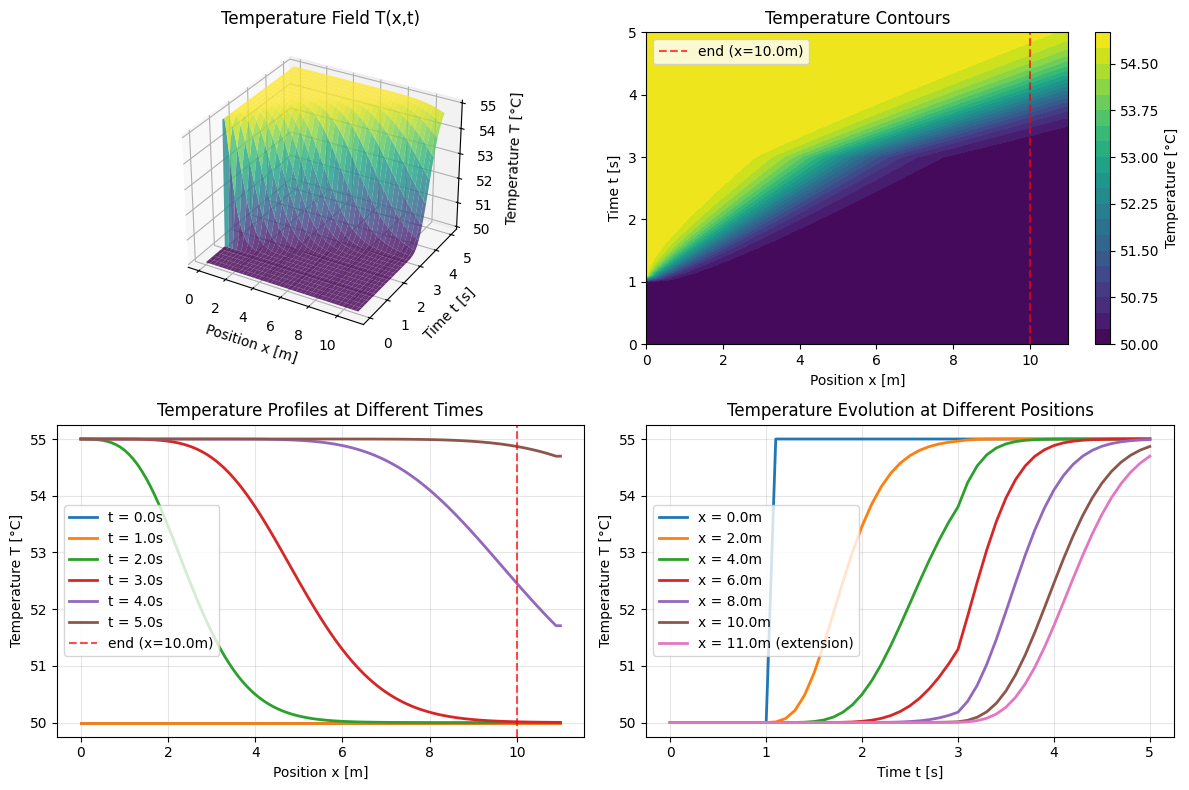


TEMPERATURE PROFILE ANALYSIS

Temperature profiles at different times:
Time [s] Inlet [K]  Mid [K]    Outlet [K] ΔT [K]    
--------------------------------------------------
0.00     323.1      323.1      323.1      0.0       
1.00     323.1      323.1      323.1      0.0       
2.00     328.1      323.2      323.2      -5.0      
3.00     328.1      325.0      323.2      -5.0      
4.00     328.1      328.1      324.9      -3.3      
5.00     328.1      328.1      327.8      -0.3      

Temperature evolution at different positions:
Position [m] Initial [K]  Final [K]    Change [K]  
--------------------------------------------------
0.00         323.1        328.1        5.0         
2.20         323.1        328.1        5.0         
4.40         323.1        328.1        5.0         
6.60         323.1        328.1        5.0         
8.80         323.1        328.1        5.0         
11.00        323.1        327.8        4.7         

Numerical diagnostics:
--------------------

In [8]:
# Create and solve the model
print("Creating pipe flow heat transport model...")
model = create_pipe_flow_model(L=10.0, t_final=5.0)

print("Adding PDE constraints...")
model = add_pde_constraints(model)

print("Solving the discretized PDE...")
results = solve_model(model, n_x=110, n_t=50, tol=1e-6)

print(f"Solver status: {results.solver.status}")
print(f"Termination condition: {results.solver.termination_condition}")

if results.solver.termination_condition == 'optimal':
    print("Plotting results...")
    fig = plot_results(
        model, 
        t_vals_to_plot=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0],
        x_vals_to_plot=[0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 11.0]
    )
    plt.tight_layout()
    plt.show()
    print_temp_profiles(model)
elif results.solver.termination_condition == 'locallyOptimal':
    print("Solution found (locally optimal). Plotting results...")
    fig = plot_results(model)
    plt.show()
else:
    print("Solution not optimal. Check model formulation.")
    print(f"Solver message: {results.solver.message}")

## Inspect Solution

In [9]:
T = pd.Series(model.T.extract_values())
T.index.names = ['t', 'x']
T = T.unstack()
T

x,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,10.1,10.2,10.3,10.4,10.5,10.6,10.7,10.8,10.9,11.0
t,,,,,,,,,,,,,,,,,,,,,
0.0,323.15,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,...,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000
0.1,323.15,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,...,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000
0.2,323.15,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,...,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000
0.3,323.15,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,...,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000
0.4,323.15,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,...,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000
0.5,323.15,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,...,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000
0.6,323.15,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,...,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000
0.7,323.15,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,...,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000
0.8,323.15,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,...,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000,323.150000
